Импортируем необходимые библиотеки

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Загружаем обработанные рисунки.

In [2]:
!rm ans_pre
!rm des_pre
!wget https://raw.githubusercontent.com/egorneo/Dess/main/ans_pre
!wget https://raw.githubusercontent.com/egorneo/Dess/main/des_pre

rm: cannot remove 'ans_pre': No such file or directory
rm: cannot remove 'des_pre': No such file or directory
--2023-04-13 09:36:05--  https://raw.githubusercontent.com/egorneo/Dess/main/ans_pre
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382825 (374K) [application/octet-stream]
Saving to: ‘ans_pre’

ans_pre             100%[===================>] 373.85K  --.-KB/s    in 0.03s   

2023-04-13 09:36:05 (10.4 MB/s) - ‘ans_pre’ saved [382825/382825]

--2023-04-13 09:36:06--  https://raw.githubusercontent.com/egorneo/Dess/main/des_pre
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP

In [ ]:
import pickle
with open ('ans_pre', 'rb') as fp:
    answers = pickle.load(fp)
with open ('des_pre', 'rb') as fp:
    des = pickle.load(fp)

print(len(des))

191191


In [3]:
# Обучение на исходном датасете
# import pickle
# with open ('ans_original', 'rb') as fp:
#     answers = pickle.load(fp)
# with open ('des_original', 'rb') as fp:
#     des = pickle.load(fp)

# print(len(des))

191


In [4]:
for i in range(4):
  print(answers.count(i)/len(answers))

0.39790575916230364
0.34554973821989526
0.225130890052356
0.031413612565445025


Каждый детский рисунок представлен стандартно в виде 3 перестановок, затем они записываются в одни длинный вектор длины 48.

Например, для того, что на картинке.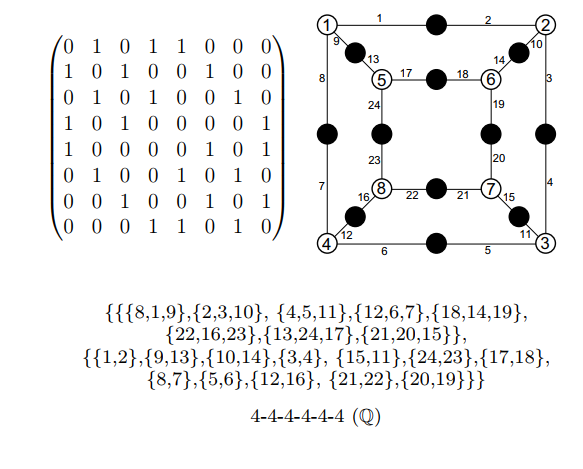

In [5]:
print(des[0])
print(f"Length = {len(des[0])}")
print(f"Galois dim = {answers[0]} (Отсчёт идёт с нуля, т.е. 0 соответствует Q)")

[8, 1, 9, 2, 3, 10, 4, 5, 11, 12, 6, 7, 18, 14, 19, 22, 16, 23, 13, 24, 17, 21, 20, 15, 1, 2, 9, 13, 10, 14, 3, 4, 15, 11, 24, 23, 17, 18, 8, 7, 5, 6, 12, 16, 21, 22, 20, 19]
Length = 48
Galois dim = 0 (Отсчёт идёт с нуля, т.е. 0 соответствует Q)


Прописываем архитектуру нейронной сети. На вход подаётся вектор длины 48 преобразуемый линейно в вектор размерности hid_size = 512, затем 5 раз применяется композиция линейного преобразования $\mathbb{R}^{512}\to\mathbb{R}^{512}$ и некоторой фиксированной нелинейной функции. На выходе вектор длины, соответсвующий "вероятности" попадания в один из 4 классов. 

In [25]:
hid_size = 512


model = nn.Sequential()
model.add_module('l1', nn.Linear(len(des[0]), hid_size))
model.add_module('activation1', nn.LeakyReLU(0.01))
model.add_module('dropout', nn.Dropout(p=0.25))
model.add_module('l2', nn.Linear(hid_size, hid_size))
model.add_module('activation2', nn.LeakyReLU(0.01))
model.add_module('dropout', nn.Dropout(p=0.25))
model.add_module('l3', nn.Linear(hid_size, hid_size))
model.add_module('activation3', nn.LeakyReLU(0.01))
model.add_module('dropout', nn.Dropout(p=0.25))
model.add_module('l4', nn.Linear(hid_size, hid_size))
model.add_module('activation4', nn.LeakyReLU(0.01))
model.add_module('dropout', nn.Dropout(p=0.25))
model.add_module('final', nn.Linear(hid_size, 4))

In [21]:
len(des)

191

Разбиваем данные на train\test. На 80 процентов данных будут оптимизироваться веса линейной части модели, на 20 процентах проверим её точность.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(des,answers,shuffle=True)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
'''
from sklearn.utils import shuffle

des, answers = shuffle(des,answers)


X_train = des[0:100000]
X_test = des[100000:]
y_train = answers[0:100000]
y_test = answers[100000:]

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
'''

train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Будем минимизировать перекрестную энтропию, как это принято при решении задачи классификации. Обучаем модель, наблюдаем, как падает эта ошибка. Эта часть в Google collab выполняется где-то 7-10 минут.

Epoch:1 out of 20
Epoch:2 out of 20
Epoch:3 out of 20
Epoch:4 out of 20
Epoch:5 out of 20
Epoch:6 out of 20
Epoch:7 out of 20
Epoch:8 out of 20
Epoch:9 out of 20
Epoch:10 out of 20
Epoch:11 out of 20
Epoch:12 out of 20
Epoch:13 out of 20
Epoch:14 out of 20
Epoch:15 out of 20
Epoch:16 out of 20
Epoch:17 out of 20
Epoch:18 out of 20
Epoch:19 out of 20
Epoch:20 out of 20


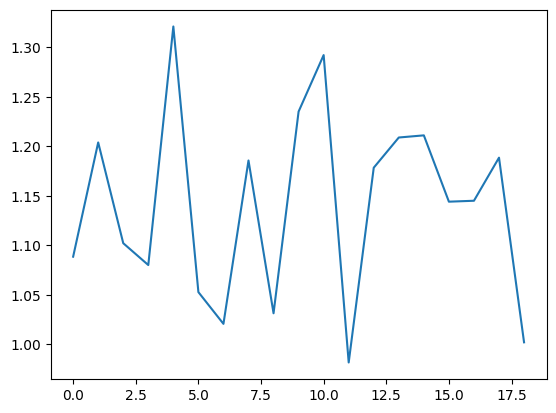

In [28]:
def train_model(model, train_data, n_epoch):
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.001)
    
    
    loss_history = []

    for epoch_num in range(n_epoch):
        print(f"Epoch:{epoch_num+1} out of {n_epoch}")
        
        model.train(True)
        for i, batch in enumerate(train_loader):
            X_batch, y_batch = batch
            
            opt.zero_grad()
            y_predicted = model(X_batch)
            loss = loss_function(y_predicted, y_batch)
            loss.backward()
            opt.step()
        loss_history.append(loss.item())

    return model, loss_history

out = train_model(model,train_loader, 20)
plt.plot(np.array(out[1][1:]), label="Loss")

Считаем ошибку на тестовой выборке. Модель показывает результат близкий к 100 процентам.


In [29]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        y_predicted = model(X_test[i])
        predicted_labels.append(y_predicted.argmax())
        real_labels.append(y_test[i])

print(predicted_labels[0:20])
print(real_labels[0:20])
test_acc = [(lambda i: 1 if(predicted_labels[i] == real_labels[i]) else 0)(i) for i in range(len(predicted_labels))]
test_acc = sum(test_acc)/len(test_acc)
print(f"Test accuracy = {test_acc}")

[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]
[tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(1), tensor(0), tensor(2), tensor(1), tensor(0), tensor(1), tensor(3)]
Test accuracy = 0.2916666666666667


In [ ]:
predicted_labels = list(map(int,predicted_labels))
print(predicted_labels)
print(f"o's = {predicted_labels.count(0)}")
print(f"1's = {predicted_labels.count(1)}")
print(f"2's = {predicted_labels.count(2)}")
print(f"3's = {predicted_labels.count(3)}")

[0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 3, 2, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 0, 3, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 3, 0, 2, 3, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 3, 0, 0, 3, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 3, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 3, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 